## This notebook checks the data quality of the dataset and performs preprocessing (just removes columns in this case).
- It looks for duplicate rows, zero-variance features, few-unique features, nulls, zeroes, outliers, and highly correlated features. <br>
- It also checks if some features are derived from others and drops them if they are. <br>
- Finally, it uses PCA to visualize the dataset in 2D. <br>

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("Dataset1.xlsx")
df.shape

(10127, 21)

In [3]:
# Duplicate rows
dup_mask = df.duplicated(keep="first")
n_dups = dup_mask.sum()
print(f"Duplicate rows: {n_dups}")

Duplicate rows: 0


In [4]:
# Zero-variance features
zero_var = [c for c in df if df[c].nunique(dropna=False) <= 1]
print(f"{len(zero_var)} zero-variance features: {zero_var}")

0 zero-variance features: []


There are no zero-variance features, lets look at features with few unique values.

In [5]:
# Few-unique features
threshold = 5
nunique = df.nunique()
few_unique = [c for c, u in nunique.items() if u <= threshold]
print(f"Features with <= {threshold} unique values ({len(few_unique)}):")
for feat in few_unique:
    print(f"- {feat}: {nunique[feat]} distinct")

Features with <= 5 unique values (4):
- Attrition_Flag: 2 distinct
- Gender: 2 distinct
- Marital_Status: 4 distinct
- Card_Category: 4 distinct


All those columns are categorical and the low number of unique values is ok.

In [6]:
# Nulls in the dataset
col_null_count = df.isnull().sum()
cols_with_nulls = col_null_count[col_null_count > 0]
print(f"Columns with nulls: {len(cols_with_nulls)}")

row_null_count = df.isnull().sum(axis=1)
rows_with_nulls = row_null_count[row_null_count > 0]
print(f"Rows with nulls: {len(rows_with_nulls)}")

Columns with nulls: 0
Rows with nulls: 0


No nulls in the dataset. Maybe some features have a lot of zeroes instead of nulls.

In [7]:
# Zeroes in the dataset
threshold = 0.05
zero_frac = (df == 0).mean()
cols_zero_or_null = zero_frac[zero_frac >= threshold]
print(f"Columns with at least 5% zeros ({len(cols_zero_or_null)}):")
for c, frac in cols_zero_or_null.items():
    print(f"- {c}: {frac:.1%} zeros")

Columns with at least 5% zeros (3):
- Dependent_count: 8.9% zeros
- Total_Revolving_Bal: 24.4% zeros
- Avg_Utilization_Ratio: 24.4% zeros


`Dependent_count` being zero sometimes is fine. <br>
The other columns can also be zeroes if the card isnt used so we will keep them. <br>
Note that the number of zeroes is equal in them, maybe they are connected, we will make sense of that later. [1]

In [8]:
# Check for outliers with abs(z-score) >= 3
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    col_data = df[col].dropna()
    mu, sigma = col_data.mean(), col_data.std()
    lower_cutoff = mu - 3 * sigma
    upper_cutoff = mu + 3 * sigma

    col_min, col_max = col_data.min(), col_data.max()

    lower_count = (col_data < lower_cutoff).sum()
    upper_count = (col_data > upper_cutoff).sum()

    if lower_count == 0 and upper_count == 0:
        continue

    print(f"Column '{col}':")
    print(f"- Full range:            {col_min:.3f} to {col_max:.3f}")

    if lower_count > 0:
        print(f"- Lower outlier range:   {col_min:.3f} to {lower_cutoff:.3f}  ({lower_count} outliers)")

    if upper_count > 0:
        print(f"- Upper outlier range:   {upper_cutoff:.3f} to {col_max:.3f}  ({upper_count} outliers)")

    print()

Column 'Customer_Age':
- Full range:            26.000 to 73.000
- Upper outlier range:   70.376 to 73.000  (1 outliers)

Column 'Months_Inactive_12_mon':
- Full range:            0.000 to 6.000
- Upper outlier range:   5.373 to 6.000  (124 outliers)

Column 'Contacts_Count_12_mon':
- Full range:            0.000 to 6.000
- Upper outlier range:   5.774 to 6.000  (54 outliers)

Column 'Total_Amt_Chng_Q4_Q1':
- Full range:            0.000 to 3.397
- Lower outlier range:   0.000 to 0.102  (12 outliers)
- Upper outlier range:   1.418 to 3.397  (151 outliers)

Column 'Total_Trans_Amt':
- Full range:            510.000 to 18484.000
- Upper outlier range:   14595.474 to 18484.000  (391 outliers)

Column 'Total_Trans_Ct':
- Full range:            10.000 to 139.000
- Upper outlier range:   135.276 to 139.000  (2 outliers)

Column 'Total_Ct_Chng_Q4_Q1':
- Full range:            0.000 to 3.714
- Upper outlier range:   1.426 to 3.714  (113 outliers)



After looking at the dataset, it does not seem that these "outliers" should be removed, the real value difference is not that much.

In [9]:
# Highly correlated features with |corr| > 0.8
threshold = 0.8
num_cols = df.select_dtypes(include=np.number)
corr = num_cols.corr(method="spearman").abs()

high_corr = []
cols = corr.columns.tolist()
for i in range(len(cols) - 1):
    for j in range(i + 1, len(cols)):
        val = corr.iat[i, j]
        if val > threshold:
            high_corr.append((cols[i], cols[j], val))

print(f"Highly correlated numeric pairs (|corr| > {threshold}): {len(high_corr)}")
if high_corr:
    for c1, c2, v in high_corr:
        print(f"  - {c1} & {c2}: corr = {v:.5f}")

Highly correlated numeric pairs (|corr| > 0.8): 2
  - Credit_Limit & Avg_Open_To_Buy: corr = 0.93143
  - Total_Trans_Amt & Total_Trans_Ct: corr = 0.87973


1. `Total_Trans_Amt` and `Total_Trans_Ct` are correlated which make sense: more transactions usually mean more money spent. <br>
  We *could* remove one of them, but their actual meaning differs so I don't think it is necessary.
2. `Credit_Limit` and `Avg_Open_To_Buy` are very correlated.

After closer inspection, it seems that `Avg_Open_To_Buy` is just `Credit_Limit - Total_Revolving_Bal`. <br>
Also, `Avg_Utilization_Ratio` seems to be `Total_Revolving_Bal / Credit_Limit` (also see [1] above). <br>
Let's double-check that.

In [10]:
n = len(df)

# 1) Check Credit_Limit == Avg_Open_To_Buy + Total_Revolving_Bal
mask1 = df["Credit_Limit"] == df["Avg_Open_To_Buy"] + df["Total_Revolving_Bal"]
n1 = mask1.sum()
print(f"Credit_Limit == Avg_Open_To_Buy + Total_Revolving_Bal: {n1}/{n} ({n1 / n:.1%})")

# 2) Check Avg_Utilization_Ratio ≈ Total_Revolving_Bal / Credit_Limit (±0.01)
mask2 = (df["Avg_Utilization_Ratio"] - df["Total_Revolving_Bal"] / df["Credit_Limit"]).abs() < 0.01
n2 = mask2.sum()
print(f"Avg_Utilization_Ratio ≈ Total_Revolving_Bal/Credit_Limit: {n2}/{n} ({n2 / n:.1%})")

Credit_Limit == Avg_Open_To_Buy + Total_Revolving_Bal: 10127/10127 (100.0%)
Avg_Utilization_Ratio ≈ Total_Revolving_Bal/Credit_Limit: 10127/10127 (100.0%)


Since the equations hold for all values, we can drop two of the columns. <br>
We should definitely keep `Credit_Limit` since it is a basic feature of the card. <br>
Out of the three remaining, keeping `Total_Revolving_Bal` OR `Avg_Utilization_Ratio` is fine. I chose to keep `Total_Revolving_Bal`.

Out of the other columns, we should also drop `CLIENTNUM` since it is just an identifier and doesn't contribute anyhow to the decision of closing the account. <br>
It only risks overfitting the model.

In [11]:
cols_to_drop = ["CLIENTNUM", "Avg_Utilization_Ratio", "Avg_Open_To_Buy"]
new_df = df.drop(columns=cols_to_drop)
new_df.to_csv("credit_card_customers.csv", index=False)
new_df.shape

(10127, 18)

Now lets use PCA to visualize the dataset. <br>

Explained variance ratio (PC1, PC2): 0.177, 0.150



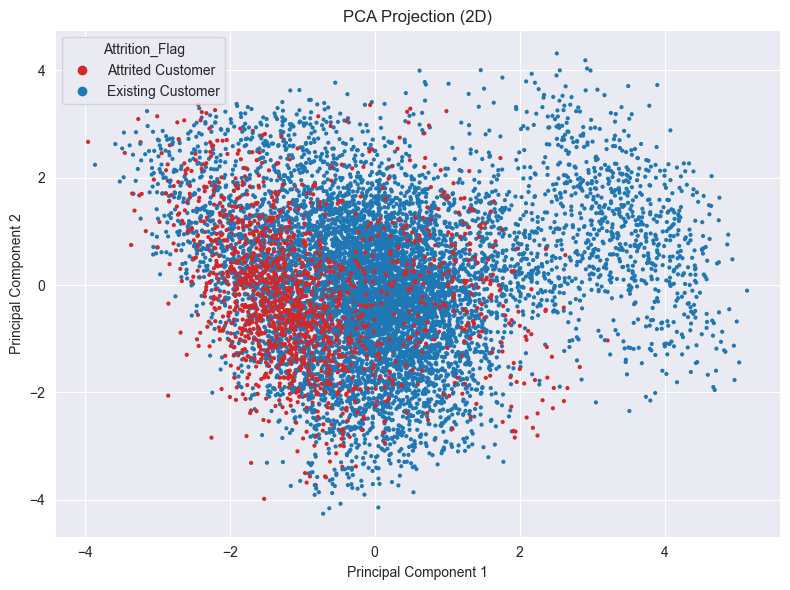

In [12]:
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

numeric_cols = new_df.select_dtypes(include=[np.number]).columns.tolist()
X = new_df[numeric_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=239)
X_pca = pca.fit_transform(X_scaled)
evr = pca.explained_variance_ratio_
print(f"Explained variance ratio (PC1, PC2): {evr[0]:.3f}, {evr[1]:.3f}\n")

color_map = {"Attrited Customer": "tab:red",
             "Existing Customer": "tab:blue"}
point_colors = new_df["Attrition_Flag"].map(color_map)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=4, c=point_colors)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection (2D)")

handles = [plt.Line2D([], [], marker="o", linestyle="",
                      color=color_map[k], label=k) for k in color_map]
plt.legend(handles=handles, title="Attrition_Flag", loc="best")

plt.tight_layout()
plt.savefig("img/pca_scatter.png", dpi=300)
plt.show()

The variance ratio of the first two principal components is small, which means that the data is not very well separated in 2D. <br>
However, we can already see that the two classes (attrited and existing customers) look different in the PCA space. <br>
(I will not use PCA in the models, just wanted to look at this scatterplot).